# Inventory Forecast using LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_excel(r"D:\Xena\project\800CT-Twin-B08QCX9WKH.xlsx",parse_dates=True)
df

,Time,Units Ordered
0,2021-02-16 00:00:00,0
1,2021-02-17 00:00:00,1
2,2021-02-18 00:00:00,1
3,2021-02-19 00:00:00,2
4,2021-02-20 00:00:00,6
...,...,...
582,2022-09-21 00:00:00,4
583,2022-09-22 00:00:00,6
584,2022-09-23 00:00:00,4
585,2022-09-24 00:00:00,3


In [3]:
type(df['Time'])

pandas.core.series.Series

In [4]:
df['Time']= pd.to_datetime(df['Time'])

In [5]:
df['Time']= df['Time'].dt.strftime('%d-%m-%Y')
df

,Time,Units Ordered
0,16-02-2021,0
1,17-02-2021,1
2,18-02-2021,1
3,19-02-2021,2
4,20-02-2021,6
...,...,...
582,21-09-2022,4
583,22-09-2022,6
584,23-09-2022,4
585,24-09-2022,3


In [6]:
df= df.set_index('Time')
df.index.names = ['Date']
df

,Units Ordered
Date,
16-02-2021,0
17-02-2021,1
18-02-2021,1
19-02-2021,2
20-02-2021,6
...,...
21-09-2022,4
22-09-2022,6
23-09-2022,4


<AxesSubplot:xlabel='Date'>

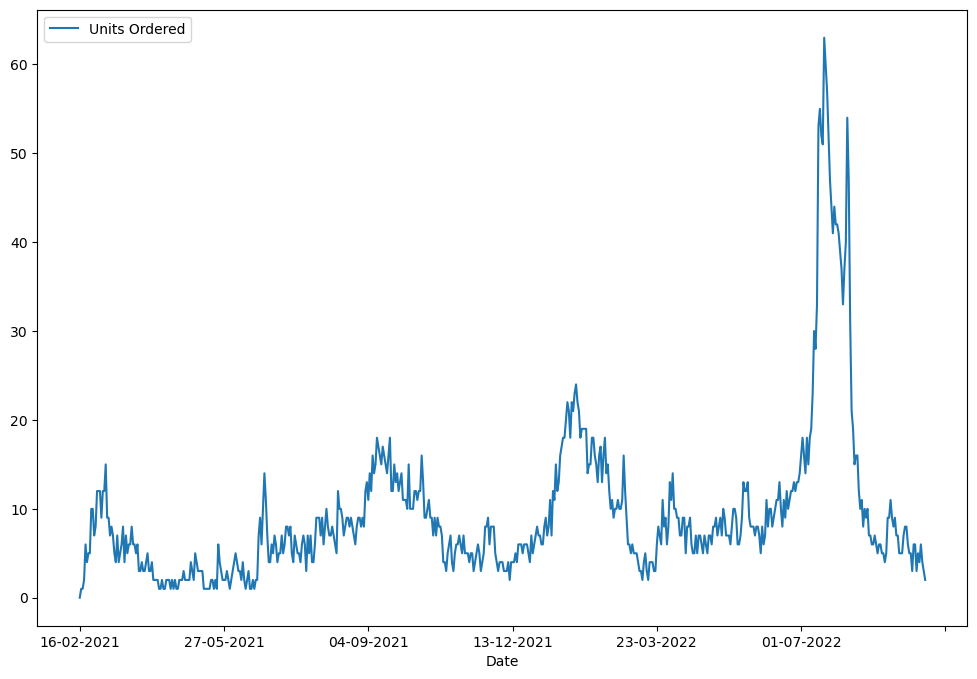

In [67]:
df.plot(figsize=(12,8))

In [8]:
#lstm doesn't depend seasonality
from statsmodels.tsa.stattools import adfuller

print("Results of Dickey fuller test")
dftest= adfuller(df['Units Ordered'], autolag='AIC')

dfout= pd.Series(dftest[0:4], index=['Test Statistics','p-value','#Lags used','Number of observations used'])
for key,value in dftest[4].items():
    dfout['Critical Values (%s)'%key]= value
print(dfout)

Results of Dickey fuller test
Test Statistics                 -3.290445
p-value                          0.015311
#Lags used                       0.000000
Number of observations used    586.000000
Critical Values (1%)            -3.441558
Critical Values (5%)            -2.866485
Critical Values (10%)           -2.569403
dtype: float64


In [9]:
train_data= df.iloc[:469]
test_data = df.iloc[469:]

In [10]:
train_data

,Units Ordered
Date,
16-02-2021,0
17-02-2021,1
18-02-2021,1
19-02-2021,2
20-02-2021,6
...,...
26-05-2022,9
27-05-2022,8
28-05-2022,8


In [11]:
test_data

,Units Ordered
Date,
31-05-2022,8
01-06-2022,8
02-06-2022,7
03-06-2022,5
04-06-2022,8
...,...
21-09-2022,4
22-09-2022,6
23-09-2022,4


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [13]:
train= scaler.fit_transform(train_data)
test= scaler.transform(test_data)

In [14]:
train.shape

(469, 1)

In [15]:
len(test)

118

In [16]:
X_train = []
Y_train = []

timesteps = 8

for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])

In [17]:
X_train,Y_train = np.array(X_train),np.array(Y_train)

In [18]:
X_train

array([[[0.        ],
        [0.04166667],
        [0.04166667],
        ...,
        [0.16666667],
        [0.20833333],
        [0.20833333]],

       [[0.04166667],
        [0.04166667],
        [0.08333333],
        ...,
        [0.20833333],
        [0.20833333],
        [0.41666667]],

       [[0.04166667],
        [0.08333333],
        [0.25      ],
        ...,
        [0.20833333],
        [0.41666667],
        [0.41666667]],

       ...,

       [[0.29166667],
        [0.375     ],
        [0.54166667],
        ...,
        [0.54166667],
        [0.375     ],
        [0.33333333]],

       [[0.375     ],
        [0.54166667],
        [0.5       ],
        ...,
        [0.375     ],
        [0.33333333],
        [0.33333333]],

       [[0.54166667],
        [0.5       ],
        [0.5       ],
        ...,
        [0.33333333],
        [0.33333333],
        [0.33333333]]])

In [19]:
X_train.shape

(461, 8, 1)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers

### Stacked LSTM

In [21]:
model = Sequential()
# model.add(LSTM(36,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,activation = 'relu'))        
# model.add(LSTM(16,activation = 'relu',return_sequences = True))
# model.add(LSTM(8,activation = 'relu'))
# model.add(Dense(1))

model.add(LSTM(126,input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,activation = 'relu'))
model.add(LSTM(126,activation = 'relu'))

model.add(Dense(32))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 126)            64512     
                                                                 
 lstm_1 (LSTM)               (None, 126)               127512    
                                                                 
 dense (Dense)               (None, 32)                4064      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 196,121
Trainable params: 196,121
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(X_train,Y_train,epochs = 100,verbose = 1,shuffle = True)

Epoch 1/100
15/15 [==============================] - 2s 13ms/step - loss: 0.0554
Epoch 2/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0166
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0110
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0098
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0095
Epoch 6/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 7/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 9/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0091
Epoch 10/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0086
Epoch 11/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0081
Epoch 12/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0083
Epoch 13/100
15/15 [=====

### Training Set

In [23]:
train_pred = model.predict(X_train)
mse = mean_squared_error(Y_train,train_pred)
rmse = np.sqrt(mse)
r = r2_score(Y_train,train_pred)
print(mse, rmse, r)

0.005441757248490738 0.0737682672189793 0.8554077226988519


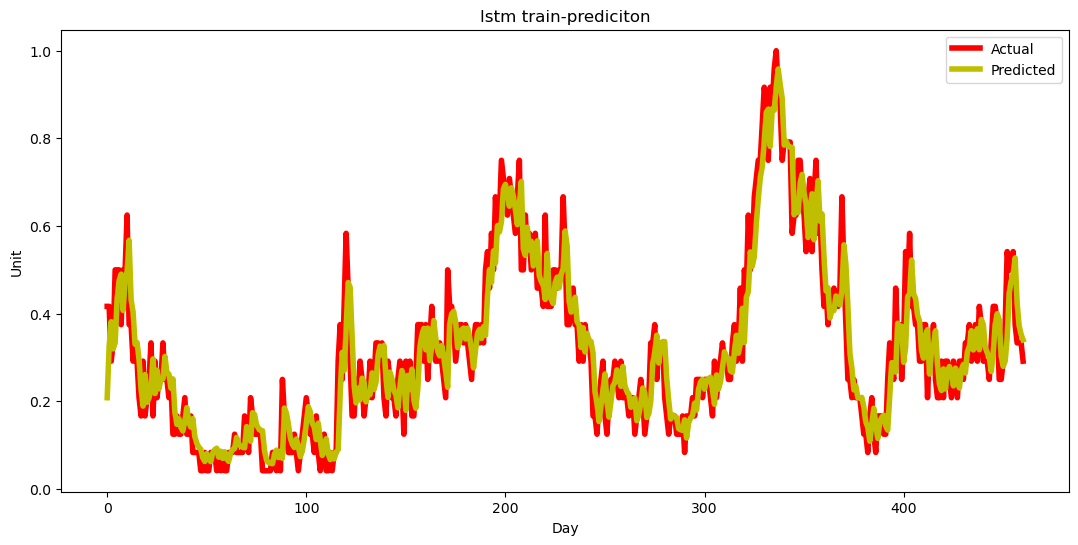

In [82]:
plt.plot(Y_train,c = 'r')
plt.plot(train_pred,c = 'y')
plt.xlabel('Day')
plt.ylabel('Unit')
plt.title('lstm train-prediciton')
plt.legend(['Actual','Predicted'],loc = 'upper right')
plt.show()

### Testing Set

In [25]:
X_test = []
Y_test = []

    # Loop for testing data
for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
X_test,Y_test = np.array(X_test),np.array(Y_test)

In [26]:
print(Y_test.shape)

(110, 1)


In [27]:
test_pred = model.predict(X_test)
mse = mean_squared_error(Y_test,test_pred)
rmse = np.sqrt(mse)
r = r2_score(Y_test,test_pred)
print(mse, rmse, r)

0.03075689538856823 0.17537643909193798 0.9304913817237638


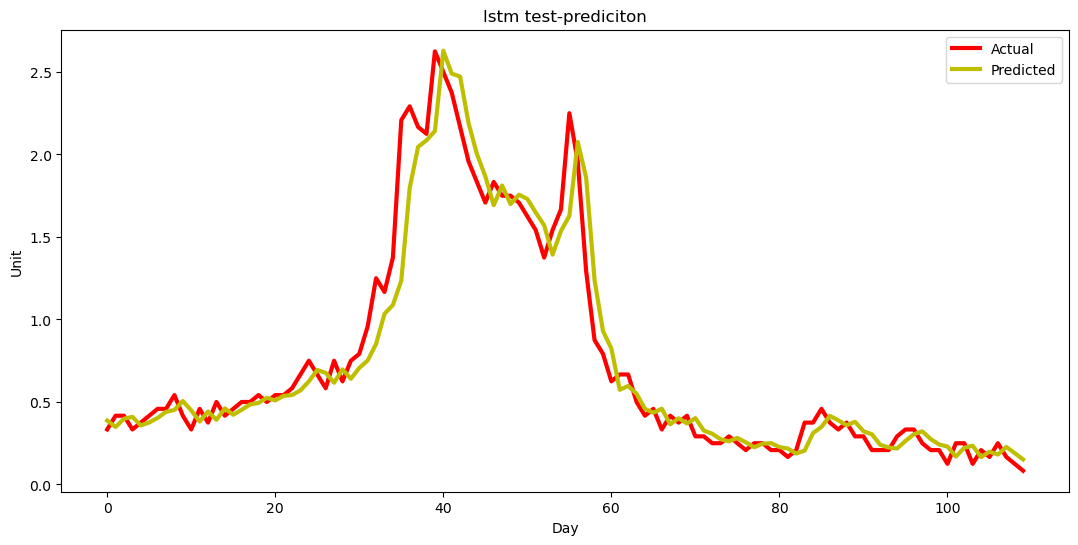

In [81]:
plt.plot(Y_test,c = 'r')
plt.plot(test_pred,c = 'y')
plt.xlabel('Day')
plt.ylabel('Unit')
plt.title('lstm test-prediciton')
plt.legend(['Actual','Predicted'],loc = 'upper right')
plt.rcParams['lines.linewidth'] = 4
plt.show()

#### MAPE Value

In [29]:
from sklearn.metrics import mean_absolute_percentage_error

np.round(mean_absolute_percentage_error(Y_test,test_pred) * 100,2)

18.05

#### Future Predictions

In [30]:
pred = []
Xinput = test[110:].reshape((1, 8, 1))
for i in range(32):
    x = model.predict(Xinput, verbose=0)
    pred.append(x[0][0]) 
    Xinput = np.append(Xinput,x[0][0])
    Xinput = Xinput[1:].reshape((1, 8, 1)) 
        

In [31]:
pred

[0.115192436,
 0.12359272,
 0.12458452,
 0.12612559,
 0.12429964,
 0.12856863,
 0.13254432,
 0.13615862,
 0.13919726,
 0.14226474,
 0.14542946,
 0.14863104,
 0.15188558,
 0.15511772,
 0.15838969,
 0.16169436,
 0.16503832,
 0.16841875,
 0.17181057,
 0.17520949,
 0.17862274,
 0.18202811,
 0.18541098,
 0.18878141,
 0.19213979,
 0.19548574,
 0.19880392,
 0.20210022,
 0.20537774,
 0.20863828,
 0.21188223,
 0.21510953]

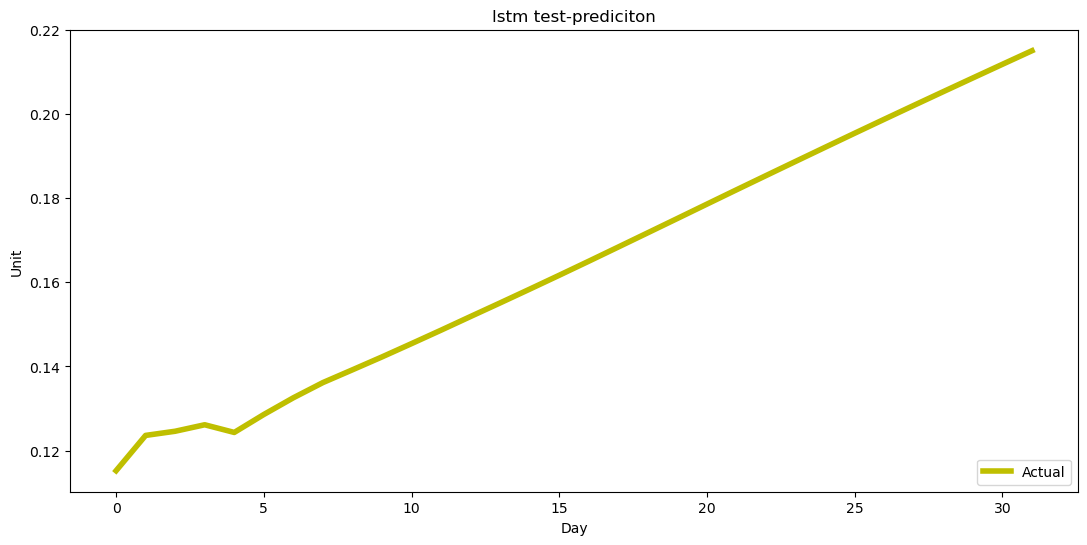

In [83]:
plt.plot(pred,c = 'y')
plt.xlabel('Day')
plt.ylabel('Unit')
plt.title('lstm test-prediciton')
plt.legend(['Actual'],loc = 'lower right')
plt.show()

In [84]:
pred1 = scaler.inverse_transform(np.array(pred).reshape(-1,1))
pred1 = np.round(pred1)

In [93]:
pred1

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [4.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.],
       [5.]], dtype=float32)

### Forecasted Plot

In [86]:
day_new=np.arange(1,119)
day_pred=np.arange(119,151)

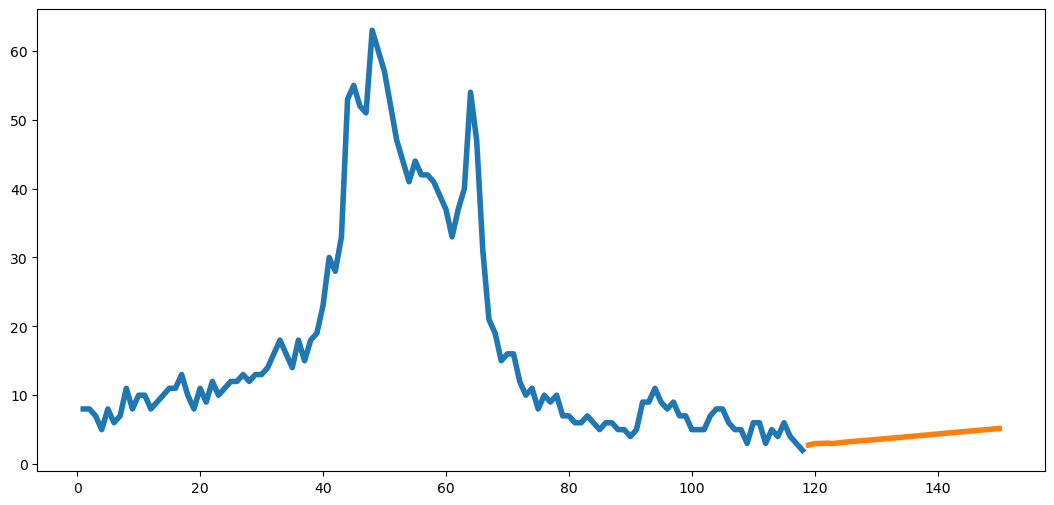

In [87]:
plt.plot(day_new,scaler.inverse_transform(test))
plt.plot(day_pred,scaler.inverse_transform(np.array(pred).reshape(-1,1)))

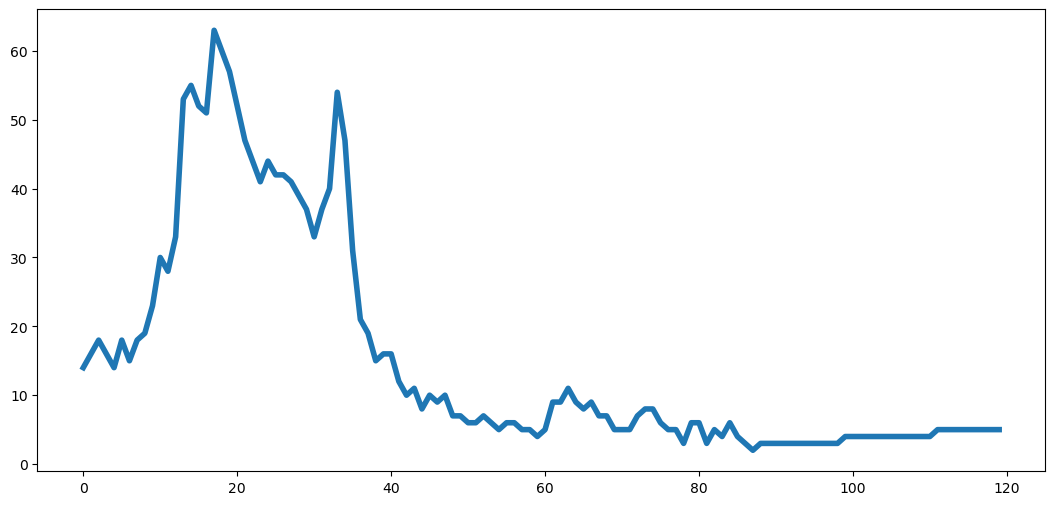

In [88]:
df1= df["Units Ordered"].tolist()
df1.extend(pred1)
plt.plot(df1[-120:])

In [99]:
actual = pd.read_excel(r"D:\Xena\project\B08QCX9WKH-Test Data.xlsx")
actual

,Time,Sales
0,2022-09-26 00:00:00,2
1,2022-09-27 00:00:00,4
2,2022-09-28 00:00:00,5
3,2022-09-29 00:00:00,5
4,2022-09-30 00:00:00,6
5,2022-10-01 00:00:00,7
6,2022-10-02 00:00:00,6
7,2022-10-03 00:00:00,6
8,2022-10-04 00:00:00,3
9,2022-10-05 00:00:00,5


In [90]:
s = sum(actual['Sales'].values)
s

129

In [94]:
sum(pred1)

array([126.], dtype=float32)

### MAPE for Actual values

In [102]:

actual['Time']= pd.to_datetime(actual['Time'])
actual['Time']= actual['Time'].dt.strftime('%d-%m-%Y')
actual= actual.set_index('Time')
actual.index.names = ['Date']
actual

,Sales,Predictions
Date,,
26-09-2022,2,3.0
27-09-2022,4,3.0
28-09-2022,5,3.0
29-09-2022,5,3.0
30-09-2022,6,3.0
01-10-2022,7,3.0
02-10-2022,6,3.0
03-10-2022,6,3.0
04-10-2022,3,3.0


### Absolute percent error is 2.3%

 Predicted = 126
 Actual = 129
